In [1]:
import os
import gc
import mne
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict

from threading import Thread
print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
autodfname = 'auto_path_table.json'
autodf = pd.read_json(autodfname)
autodf

,emnoises,raws,restings
EEG_S01,[],"{'10': '20190402_RSVP_EEG_S01/10.cnt', '02': '...",[]
EEG_S02,[],"{'10': '20190402_RSVP_EEG_S02/10.cnt', '02': '...",[]
EEG_S03,[],"{'10': '20191230_RSVP_EEG_S03/10.cnt', '11': '...","[20191230_RSVP_EEG_S03/r1.cnt, 20191230_RSVP_E..."
EEG_S04,[],"{'10': '20200104_RSVP_EEG_S04/10.cnt', '11': '...","[20200104_RSVP_EEG_S04/r1.cnt, 20200104_RSVP_E..."
EEG_S05,[Noise-default_Noise_20200107_02.ds],"{'10': '20200107-RSVP_EEG_S05/10.cnt', '11': '...","[20200107-RSVP_EEG_S05/r1.cnt, 20200107-RSVP_E..."
EEG_S06,[],"{'10': '20200106_RSVP_EEG_S06/10.cnt', '11': '...","[20200106_RSVP_EEG_S06/r1.cnt, 20200106_RSVP_E..."
EEG_S07,[],"{'10': '20200106_RSVP_EEG_S07/10.cnt', '11': '...","[20200106_RSVP_EEG_S07/r1.cnt, 20200106_RSVP_E..."
EEG_S08,[],"{'10': '20200111-RSVP_EEG_S08/10.cnt', '11': '...","[20200111-RSVP_EEG_S08/r1.cnt, 20200111-RSVP_E..."
EEG_S09,[],"{'10': '20200104_RSVP_EEG_S09/10.cnt', '11': '...","[20200104_RSVP_EEG_S09/r1.cnt, 20200104_RSVP_E..."
MEG_S01,"[Noise-default_Noise_20190326_01.ds, Noise-def...",{'04': '20190326_RSVP_MEG_S01/S01_lixiangTHU_2...,[20190326_RSVP_MEG_S01/rS01-resting_lixiangTHU...


In [3]:
iter_freqs = [
    ('Delta', 1, 4),
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
#     ('Beta', 13, 25),
#     ('Gamma', 30, 45),
#     ('Cb_U04', 0.1, 4),
    ('Cb_U07', 0.1, 7),
#     ('Cb_U12', 0.1, 12),
    ('Cb_U30', 0.1, 30),
]

n_jobs = 48

tmin, tmax = -0.2, 1.2

--------------------------------------------------------------------------------
MEG_S03
Opening raw data file processed_data/MEG_S03/block_06_ica-raw.fif...
    Read 5 compensation matrices
    Range : 0 ... 290111 =      0.000 ...   241.759 secs
Ready.
Current compensation grade : 3
Opening raw data file processed_data/MEG_S03/block_10_ica-raw.fif...
    Read 5 compensation matrices
    Range : 0 ... 272687 =      0.000 ...   227.239 secs
Ready.
Current compensation grade : 3
Opening raw data file processed_data/MEG_S03/block_05_ica-raw.fif...
    Read 5 compensation matrices
    Range : 0 ... 301967 =      0.000 ...   251.639 secs
Ready.
Current compensation grade : 3
Opening raw data file processed_data/MEG_S03/block_08_ica-raw.fif...
    Read 5 compensation matrices
    Range : 0 ... 288143 =      0.000 ...   240.119 secs
Ready.
Current compensation grade : 3
Opening raw data file processed_data/MEG_S03/block_09_ica-raw.fif...
    Read 5 compensation matrices
    Range : 0 ... 271

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  24 tasks      | elapsed:    8.5s
[Parallel(n_jobs=48)]: Done 114 tasks      | elapsed:    9.5s
[Parallel(n_jobs=48)]: Done 240 tasks      | elapsed:   10.9s
[Parallel(n_jobs=48)]: Done 301 out of 301 | elapsed:   11.4s finished


11575 matching events found
Applying baseline correction (mode: mean)
Removing 5 compensators from info because not all compensation channels were picked.
Not setting metadata
0 projection items activated


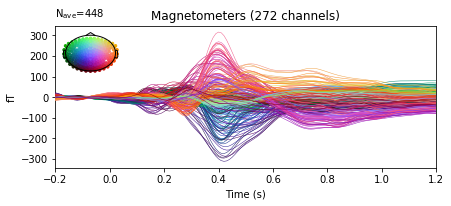

Reading 0 ... 2355551  =      0.000 ...  1962.959 secs...
Filtering raw data in 8 contiguous segments
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 39601 samples (33.001 sec)



[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  24 tasks      | elapsed:   13.7s
[Parallel(n_jobs=48)]: Done 114 tasks      | elapsed:   14.9s
[Parallel(n_jobs=48)]: Done 240 tasks      | elapsed:   16.1s
[Parallel(n_jobs=48)]: Done 301 out of 301 | elapsed:   16.6s finished


11575 matching events found
Applying baseline correction (mode: mean)
Removing 5 compensators from info because not all compensation channels were picked.
Not setting metadata
0 projection items activated


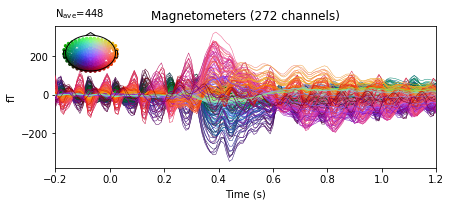

In [4]:
for exper in autodf.index:
    exper = 'MEG_S03'
    print('-' * 80)
    print(exper)
    if exper.startswith('EEG'):
        continue
    rawraw = mne.concatenate_raws([mne.io.read_raw_fif(os.path.join('processed_data', exper, e)) for e in os.listdir(os.path.join('processed_data', exper)) if e.endswith('_ica-raw.fif')])

    MVPA_predict_df = pd.DataFrame()

    # Filter events
    events = False
    if exper.startswith('MEG'):
        picks = 'mag'
        decim = 12
        events = mne.find_events(rawraw, stim_channel='UPPT001')
    if exper.startswith('EEG'):
        picks = 'eeg'
        decim = 10
        events = mne.events_from_annotations(rawraw)[0]
    assert(events is not False)
    
    # Copy raw and filter rr
    l_freq, h_freq = 0.1, 7
    rr = rawraw.copy()
    rr.load_data()
    rr.filter(l_freq=l_freq, h_freq=h_freq, n_jobs=n_jobs)
    # Get epochs
    epochs = mne.Epochs(rr, events, picks=picks, tmin=tmin, tmax=tmax, decim=decim)
    # Get evoked
    evoked_u7 = epochs['1'].average()
    evoked_u7.plot(spatial_colors=True)
    
    # Copy raw and filter rr
    l_freq, h_freq = 0.1, 30
    rr = rawraw.copy()
    rr.load_data()
    rr.filter(l_freq=l_freq, h_freq=h_freq, n_jobs=n_jobs)
    # Get epochs
    epochs = mne.Epochs(rr, events, picks=picks, tmin=tmin, tmax=tmax, decim=decim)
    # Get evoked
    evoked_u30 = epochs['1'].average()
    evoked_u30.plot(spatial_colors=True)
    
    break

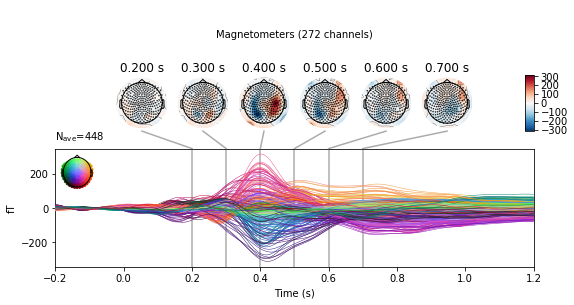

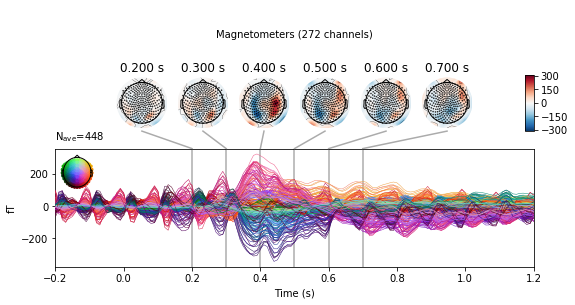

In [5]:
fig1 = evoked_u7.plot_joint(times=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
fig2 = evoked_u30.plot_joint(times=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

In [6]:
for fig, name in zip([fig1, fig2], ['joint_U07', 'joint_U30']):
    fig.set_dpi(300)
    fig.savefig('{}.png'.format(name))


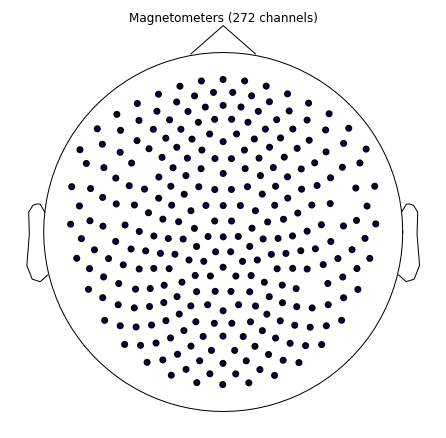

In [7]:
fig = mne.viz.plot_sensors(rawraw.info, title='Magnetometers (272 channels)')
fig.set_dpi(300)
fig.savefig('sensors.png')